### build 2D CNN (modified pattern from https://keras.io/examples/cifar10_cnn)

In [1]:
# import general dependencies
import ast          # new library: abstract syntax trees!
from matplotlib import pyplot
import numpy as np
import os
import pandas as pd

In [2]:
# import ML dependencies
from __future__ import print_function
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
import lib.MakeCIFAR10StyleModel

Using TensorFlow backend.


### define parameters

In [3]:
# set params
strPath = '.'
strModelRoot = 'CIFAR10Style_doctordata_Online'
strYCategory = 'Ethnicity' # possible values are 'DoYouDrink', 'DoYouHaveACar', 'DoYouHaveChildren',
                           # 'DoYouWantChildren', 'Education', 'Ethnicity', 'EyeColor', 'For', 'HairColor',
                           # 'HowAmbitiousAreYou', 'Intent', 'LongestRelationship', 'MaritalStatus', 
                           # 'Personality', 'Pets', 'ZodiacSign'

### import pictures as dataset for independent (X) vars

In [4]:
# create X data set
strImgPath = '../ek_scrape/img/doctordata/Online'
lstUsername = []
lstImg = []
for root, dirs, lstFile in os.walk(strImgPath):
    lstFile.sort()
    for strFile in lstFile:
        if strFile[-6:] == '00.png' and strFile != 'TraumaInTheUSA.00.png': # and strFile != 'Trini1971.00.png': # get first pic, and skip 2 bad recs
            print(strFile)
            lstUsername.append(strFile[:-7])
            img = pyplot.imread(strImgPath + '/' + strFile, format='jpg')
            arrImg = image.img_to_array(img)
            lstImg.append(arrImg)
arrX = np.array(lstImg)
arrX.shape

13D.00.png
1KindOfLove.00.png
1PrettyFeetChef1.00.png
1STREAD.00.png
1cyndi.00.png
210Frances.00.png
210shine.00.png
22aries74.00.png
2705alicia.00.png
2k18blessings.00.png
47Strings.00.png
4blonde4.00.png
512martinez.00.png
51Izzy.00.png
5Dallamakeyahalla.00.png
71NOexpectations.00.png
76Bluesky39.00.png
80ma.00.png
81vegasgirl.00.png
8bellaleah8.00.png
96jennifer.00.png
AEW1977.00.png
AGirlLooking.00.png
ATXgirl322.00.png
Adianne70.00.png
AkilaUno.00.png
Alejandra3.00.png
AlluringEJ.00.png
Amycast1.00.png
Andhereweareagain.00.png
Andi010274.00.png
Andreag11.00.png
Angel601.00.png
AngelbabyinSA.00.png
Annapblp.00.png
Armcandy13.00.png
AshTX.00.png
Aubie019.00.png
Austin6702.00.png
AydnilSantiago.00.png
Az18714.00.png
BBW43.00.png
Babe62.00.png
BabyGirlSA.00.png
BeHappy58.00.png
BeachSick.00.png
Bebepong29.00.png
Becca5013.00.png
BelieveInDestiny2009.00.png
Believedj.00.png
BellaHeart7777.00.png
Bellablonde1.00.png
Bindykins.00.png
Blkgrlnxtdr.00.png
BonnBonn1970.00.png
BossLadyCyn.00.

nu2townatx.00.png
oldschooltex.00.png
ophelia18.00.png
pabloescobarsbabymama.00.png
pamhenderson027.00.png
persianna.00.png
pinkintx.00.png
pinkstar813.00.png
pinky3850.00.png
pkutex06.00.png
plussizedsistah.00.png
pniqueen.00.png
pomk85.00.png
prcanno.00.png
prettygirl3085.00.png
prettylilthing512.00.png
princessandria.00.png
princesscharming.00.png
rachell1120.00.png
reddrover48.00.png
redinsa.00.png
rmartinez62.00.png
roadneed101.00.png
rockee74.00.png
rose197402.00.png
rubys1981.00.png
sabelle30.00.png
sammy716.00.png
sandrasatx.00.png
satxsaa26.00.png
scubakat7.00.png
sever1786.00.png
sexualred2.00.png
sexyme41.00.png
shadesofredd.00.png
shannadcc.00.png
sherrimiller228.00.png
shesliketexas.00.png
skylight84.00.png
sl2781.00.png
smbd75.00.png
smiley4uu4me.00.png
smiley7919.00.png
smmcou84.00.png
southaustinnicegirl1.00.png
southstar5.00.png
splatina.00.png
srort05.00.png
stefdref.00.png
stephgjmt.00.png
stillwaiting4unow.00.png
sugarg73.00.png
sungirltx.00.png
sunniatx.00.png
suns

(572, 110, 110, 3)

In [5]:
# change lstUsername into dataframe--will be used to filter profiles later 
dfUsername = pd.DataFrame({'username':lstUsername})

### read Profile data

In [6]:
# read JSON from file. "pof_output.txt" encoding is Windows-style "cp1252"
strProfilePath = "../ek_scrape/img/doctordata/Online/pof_output.txt"
with open(strProfilePath, 'r', encoding = 'cp1252') as file:
    strFile = file.read()
    dictProfile = ast.literal_eval(ast.literal_eval(strFile).decode("utf-8"))

In [7]:
# AddFieldsFromDictCol() converts one dictionary-style column into multiple discrete columns
def AddFieldsFromDictCol(df, strDictCol):
    dfTemp = df[strDictCol].apply(pd.Series) # .apply(pd.Series) is my favorite method EVER
    for strCol in dfTemp.columns:
        if strCol.strip() not in df.columns:
            df[strCol.strip()] = dfTemp[strCol]
    return df

In [8]:
# dump all fields to dataframe
lstCol = ['username', 'headline', 'profile_info_1', 'profile_info_2', 'interests', 'about_me_text']
dfAll = pd.DataFrame.from_dict(dictProfile, orient = 'index', columns = lstCol)

In [9]:
# convert dictionary-style columns to discrete columns and drop the dictionary columns
# this causes some columns to be mis-labelled--that'll be fixed below
for strCol in ['profile_info_1', 'profile_info_2']:
    dfAll = AddFieldsFromDictCol(dfAll, strCol)
    dfAll = dfAll.drop(strCol, axis=1)

### reformat Profile data. Categorical cols will be tested as dependent (Y) vars

In [10]:
# drop all the "About" columns, records with NaN in "Details"
dfAll = dfAll[dfAll.columns.drop(list(dfAll.filter(regex='About.*')))]
dfAll = dfAll.dropna(subset=['Details'])

In [11]:
# build new fields from existing data
dfAll['Age'] = dfAll['Details'].str.strip().str[0:2].astype('int')
dfAll['Gender'] = dfAll['Details'].str.strip().str[12:13]
dfAll['Zodiac Sign'] = dfAll['Ethnicity'].str.split(', ').str[1]
dfAll['Ethnicity'] = dfAll['Ethnicity'].str.split(', ').str[0]
dfAll['Intent'] = dfAll['Intent'].str.replace('^\S+\s?', '')

In [12]:
# strip whitespace from text columns
for strCol in dfAll.columns:
    if dfAll[strCol].dtype == 'object':
        dfAll[strCol] = dfAll[strCol].str.strip()

In [13]:
# drop unneeded columns (some col labels are still shifted)
dfAll = dfAll[dfAll.columns.drop(['headline', 'City', 'interests', 'about_me_text',
                                  'Details', 'Profession', 'For', 'Chemistry',
                                  'Do you drink?', 'Hair Color', 'Gender', 'Interests'])]

In [14]:
# fix shifted column names
dfAll = dfAll.rename(columns={'Needs Test':'For', 'Do you want children?':'DoYouDrink', 
                              'Marital Status':'DoYouWantChildren', 'Do you do drugs?':'MaritalStatus', 
                              'Eye Color':'HairColor', 'Do you have a car?':'EyeColor', 
                              'Do you have children?':'DoYouHaveACar', 
                              'Longest Relationship':'DoYouHaveChildren', 
                              'How ambitious are you?':'LongestRelationship', 
                              'Pets':'HowAmbitiousAreYou', 'Second Language':'Pets', 'Zodiac Sign':'ZodiacSign'})

In [15]:
# merge with dfUsername, and sort
dfFinal = pd.merge(dfAll, dfUsername, on='username')
dfFinal = dfFinal.sort_values(['username'])

In [16]:
dfFinal

,username,Ethnicity,Intent,Education,Personality,For,DoYouDrink,DoYouWantChildren,MaritalStatus,HairColor,EyeColor,DoYouHaveACar,DoYouHaveChildren,LongestRelationship,HowAmbitiousAreYou,Pets,Age,ZodiacSign
171,13D,Black,is actively seeking a relationship.,Some college,Free Thinker,Long Term,Socially,Does not want children,Single,Red,Brown,Yes,All my kids are over 18,Over 7 years,Ambitious,NaN,50,Cancer
158,1KindOfLove,Caucasian,is actively seeking a relationship.,Some University,Animal Lover,Long Term,Socially,Does not want children,Single,Blond(e),Green,Yes,No,Over 7 years,Ambitious,NaN,50,Capricorn
239,1PrettyFeetChef1,Caucasian,is actively seeking a relationship.,Bachelors Degree,Free Thinker,Long Term,Socially,Does not want children,Divorced,Blond(e),Green,Yes,All my kids are over 18,Over 10 years,Very Ambitious,NaN,52,Capricorn
121,1STREAD,Black,is actively seeking a relationship.,Bachelors Degree,Athletic,Dating,Socially,Does not want children,Single,Mixed Color,Brown,Yes,All my kids are over 18,Over 4 years,Very Ambitious,NaN,49,Capricorn
217,1cyndi,Caucasian,is looking for a relationship.,Associates Degree,Hopeless Romantic,Long Term,Socially,Prefer Not To Say,Divorced,Brown,Brown,Yes,Yes,Over 7 years,Ambitious,NaN,56,Aquarius
191,210Frances,Hispanic,wants to date but nothing serious.,High school,Hopeless Romantic,Hang Out,Socially,Does not want children,Divorced,Brown,Hazel,Yes,All my kids are over 18,Over 10 years,Somewhat Ambitious,Dog,60,Aries
309,210shine,Hispanic,wants to date but nothing serious.,High school,Foodie,Hang Out,Socially,Does not want children,Single,Black,Brown,Yes,All my kids are over 18,Over 10 years,Not Ambitious,NaN,39,Taurus
267,22aries74,Black,wants to date but nothing serious.,Bachelors Degree,Free Thinker,Hang Out,Socially,Does not want children,Single,Black,Brown,Yes,Yes,Over 10 years,Ambitious,NaN,45,Aries
255,2705alicia,Hispanic,wants to find someone to marry.,Bachelors Degree,Adventurer,Long Term,Socially,Want children,Single,Black,Brown,Yes,No,Over 7 years,Somewhat Ambitious,No Pets,38,Gemini
490,2k18blessings,Black,is looking for a relationship.,Bachelors Degree,Poet,Long Term,Socially,Does not want children,Divorced,Black,Brown,Yes,All my kids are over 18,Over 10 years,Very Ambitious,NaN,57,Capricorn


### start modeling

In [17]:
# define Y dataset
dfFinal[strYCategory] = dfFinal[strYCategory].astype('category')
dfFinal[strYCategory].value_counts()

Caucasian          225
Hispanic           180
Black              112
Mixed Race          29
Other Ethnicity     14
Asian                7
Native American      4
Indian               1
Name: Ethnicity, dtype: int64

In [18]:
# transform Y dataset categories to integers
dfFinal[strYCategory + '_int'] = dfFinal[strYCategory].cat.codes
arrY = dfFinal[strYCategory + '_int']
arrY.value_counts()

2    225
3    180
1    112
5     29
7     14
0      7
6      4
4      1
Name: Ethnicity_int, dtype: int64

In [19]:
# show the integer mapping of each category value, and the count in the dataset
dfYCat = dfFinal[[strYCategory + '_int', strYCategory]]
dfYCat['count'] = 1
grpYCat = dfYCat.groupby([strYCategory + '_int', strYCategory])
dfYCat = grpYCat.count().dropna().reset_index()
dfYCat

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Ethnicity_int,Ethnicity,count
0,0,Asian,7.0
1,1,Black,112.0
2,2,Caucasian,225.0
3,3,Hispanic,180.0
4,4,Indian,1.0
5,5,Mixed Race,29.0
6,6,Native American,4.0
7,7,Other Ethnicity,14.0


In [20]:
# create dictionary of integers and categories
dictYCat = dict(zip(dfYCat[strYCategory + '_int'], dfYCat[strYCategory]))
dictYCat

{0: 'Asian',
 1: 'Black',
 2: 'Caucasian',
 3: 'Hispanic',
 4: 'Indian',
 5: 'Mixed Race',
 6: 'Native American',
 7: 'Other Ethnicity'}

In [21]:
# create Train and Test datasets
arrTrainX, arrTestX, arrTrainY, arrTestY = train_test_split(arrX, arrY, random_state=17) # , stratify=arrY)
intClassCount = len(arrTrainY.value_counts())

In [22]:
# Convert class vectors to binary class matrices.
arrTrainY = keras.utils.to_categorical(arrTrainY, intClassCount)
arrTestY = keras.utils.to_categorical(arrTestY, intClassCount)

In [23]:
# create model
model = lib.MakeCIFAR10StyleModel.Go(arrTrainX, arrTestX, arrTrainY, arrTestY, intClassCount)

Instructions for updating:
Colocations handled automatically by placer.
Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
429/429 [==============================] - 13s 31ms/step - loss: 2.1540 - accuracy: 0.2168
Epoch 2/5
429/429 [==============================] - 13s 31ms/step - loss: 1.5040 - accuracy: 0.3473
Epoch 3/5
429/429 [==============================] - 13s 30ms/step - loss: 1.4842 - accuracy: 0.3683
Epoch 4/5
429/429 [==============================] - 12s 29ms/step - loss: 1.4659 - accuracy: 0.3823
Epoch 5/5
429/429 [==============================] - 13s 31ms/step - loss: 1.4559 - accuracy: 0.3846


In [24]:
# save model and weights
if not os.path.isdir(strPath):
    os.makedirs(strPath)
strModelPath = os.path.join(strPath, strModelRoot + '_' + strYCategory + '.h5')
model.save(strModelPath)
print('Saved trained model at %s ' % strModelPath)

Saved trained model at .\CIFAR10Style_doctordata_Online_Ethnicity.h5 


In [25]:
# score trained model
arrScores = model.evaluate(arrTestX, arrTestY, verbose=1)
arrPredict = model.predict_classes(arrTestX)
print('Test loss:', arrScores[0])
print('Test accuracy:', arrScores[1])

143/143 [==============================] - 1s 10ms/step
Test loss: 8.15503325162234
Test accuracy: 0.4615384638309479


In [26]:
arrPredict

array([2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 1, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2], dtype=int64)

In [27]:
dfYCat

,Ethnicity_int,Ethnicity,count
0,0,Asian,7.0
1,1,Black,112.0
2,2,Caucasian,225.0
3,3,Hispanic,180.0
4,4,Indian,1.0
5,5,Mixed Race,29.0
6,6,Native American,4.0
7,7,Other Ethnicity,14.0


In [34]:
# reverse keras.utils.to_categorical(arrTestY)
arrTestY = np.argmax(arrTestY,axis=1)

person 0:
Actual: Caucasian
Predicted: Caucasian


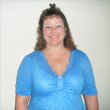

person 1:
Actual: Caucasian
Predicted: Caucasian


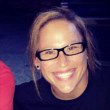

person 2:
Actual: Black
Predicted: Caucasian


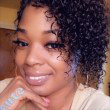

person 3:
Actual: Mixed Race
Predicted: Caucasian


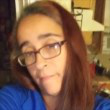

person 5:
Actual: Caucasian
Predicted: Caucasian


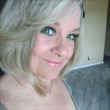

person 6:
Actual: Black
Predicted: Caucasian


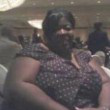

person 7:
Actual: Mixed Race
Predicted: Caucasian


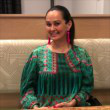

person 8:
Actual: Caucasian
Predicted: Caucasian


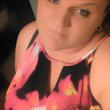

person 9:
Actual: Hispanic
Predicted: Caucasian


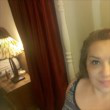

person 10:
Actual: Hispanic
Predicted: Caucasian


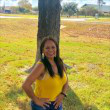

person 12:
Actual: Black
Predicted: Caucasian


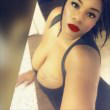

person 13:
Actual: Caucasian
Predicted: Caucasian


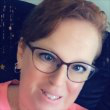

person 14:
Actual: Caucasian
Predicted: Caucasian


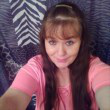

person 15:
Actual: Mixed Race
Predicted: Caucasian


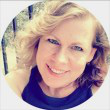

person 16:
Actual: Hispanic
Predicted: Caucasian


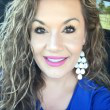

person 18:
Actual: Black
Predicted: Caucasian


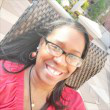

person 19:
Actual: Caucasian
Predicted: Caucasian


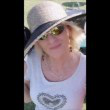

person 20:
Actual: Hispanic
Predicted: Caucasian


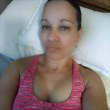

person 21:
Actual: Mixed Race
Predicted: Caucasian


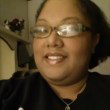

person 23:
Actual: Hispanic
Predicted: Caucasian


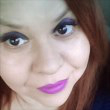

person 24:
Actual: Caucasian
Predicted: Caucasian


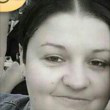

person 25:
Actual: Caucasian
Predicted: Caucasian


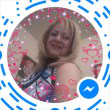

person 26:
Actual: Caucasian
Predicted: Caucasian


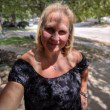

person 27:
Actual: Hispanic
Predicted: Caucasian


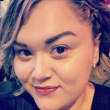

person 28:
Actual: Black
Predicted: Caucasian


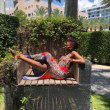

person 30:
Actual: Hispanic
Predicted: Caucasian


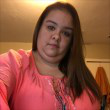

person 32:
Actual: Hispanic
Predicted: Caucasian


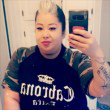

person 33:
Actual: Hispanic
Predicted: Caucasian


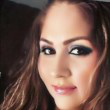

person 34:
Actual: Caucasian
Predicted: Caucasian


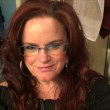

person 36:
Actual: Other Ethnicity
Predicted: Caucasian


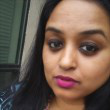

person 37:
Actual: Caucasian
Predicted: Caucasian


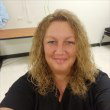

person 38:
Actual: Caucasian
Predicted: Caucasian


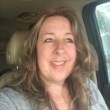

person 40:
Actual: Caucasian
Predicted: Caucasian


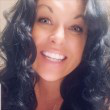

person 41:
Actual: Black
Predicted: Caucasian


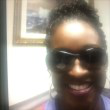

person 43:
Actual: Hispanic
Predicted: Caucasian


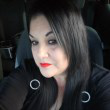

person 44:
Actual: Hispanic
Predicted: Caucasian


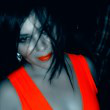

person 45:
Actual: Hispanic
Predicted: Caucasian


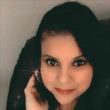

person 46:
Actual: Black
Predicted: Caucasian


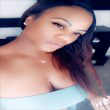

person 48:
Actual: Hispanic
Predicted: Caucasian


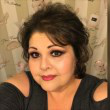

person 49:
Actual: Black
Predicted: Caucasian


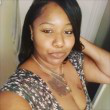

person 50:
Actual: Caucasian
Predicted: Caucasian


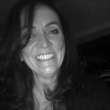

person 51:
Actual: Hispanic
Predicted: Caucasian


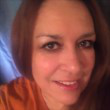

person 52:
Actual: Caucasian
Predicted: Caucasian


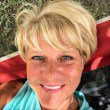

person 53:
Actual: Black
Predicted: Caucasian


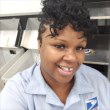

person 54:
Actual: Hispanic
Predicted: Caucasian


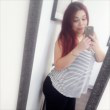

person 55:
Actual: Caucasian
Predicted: Caucasian


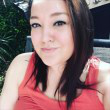

person 56:
Actual: Caucasian
Predicted: Caucasian


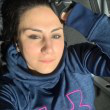

person 57:
Actual: Caucasian
Predicted: Caucasian


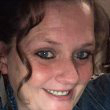

person 58:
Actual: Caucasian
Predicted: Caucasian


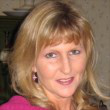

person 60:
Actual: Asian
Predicted: Caucasian


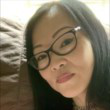

person 61:
Actual: Black
Predicted: Caucasian


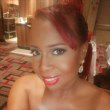

person 62:
Actual: Caucasian
Predicted: Caucasian


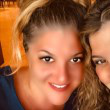

person 63:
Actual: Caucasian
Predicted: Caucasian


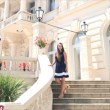

person 64:
Actual: Hispanic
Predicted: Caucasian


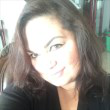

person 65:
Actual: Caucasian
Predicted: Caucasian


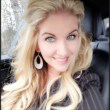

person 66:
Actual: Black
Predicted: Caucasian


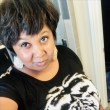

person 67:
Actual: Caucasian
Predicted: Caucasian


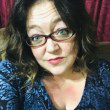

person 68:
Actual: Hispanic
Predicted: Caucasian


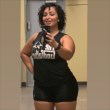

person 69:
Actual: Hispanic
Predicted: Caucasian


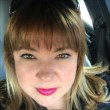

person 70:
Actual: Other Ethnicity
Predicted: Caucasian


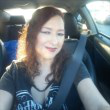

person 72:
Actual: Caucasian
Predicted: Caucasian


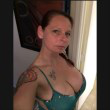

person 73:
Actual: Black
Predicted: Caucasian


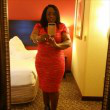

person 74:
Actual: Black
Predicted: Caucasian


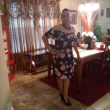

person 75:
Actual: Caucasian
Predicted: Caucasian


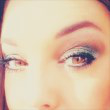

person 76:
Actual: Black
Predicted: Caucasian


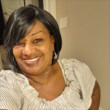

person 77:
Actual: Black
Predicted: Caucasian


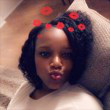

person 78:
Actual: Black
Predicted: Caucasian


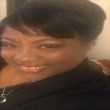

person 81:
Actual: Hispanic
Predicted: Caucasian


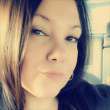

person 82:
Actual: Hispanic
Predicted: Caucasian


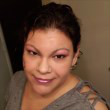

person 83:
Actual: Caucasian
Predicted: Caucasian


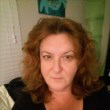

person 84:
Actual: Caucasian
Predicted: Caucasian


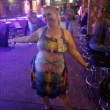

person 85:
Actual: Caucasian
Predicted: Caucasian


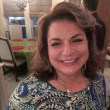

person 86:
Actual: Caucasian
Predicted: Caucasian


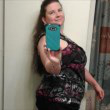

person 87:
Actual: Black
Predicted: Caucasian


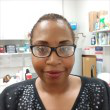

person 88:
Actual: Hispanic
Predicted: Caucasian


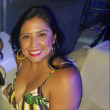

person 91:
Actual: Caucasian
Predicted: Caucasian


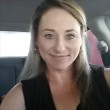

person 92:
Actual: Caucasian
Predicted: Caucasian


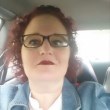

person 93:
Actual: Hispanic
Predicted: Caucasian


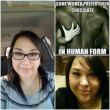

person 94:
Actual: Caucasian
Predicted: Caucasian


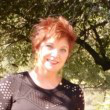

person 95:
Actual: Caucasian
Predicted: Caucasian


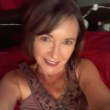

person 96:
Actual: Caucasian
Predicted: Caucasian


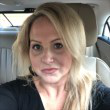

person 97:
Actual: Caucasian
Predicted: Caucasian


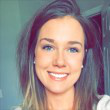

person 99:
Actual: Black
Predicted: Caucasian


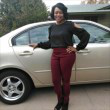

person 101:
Actual: Native American
Predicted: Caucasian


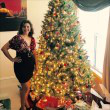

person 102:
Actual: Hispanic
Predicted: Caucasian


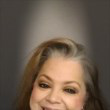

person 103:
Actual: Black
Predicted: Caucasian


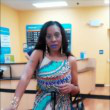

person 104:
Actual: Caucasian
Predicted: Caucasian


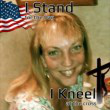

person 105:
Actual: Caucasian
Predicted: Caucasian


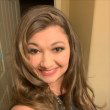

person 106:
Actual: Hispanic
Predicted: Caucasian


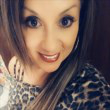

person 107:
Actual: Caucasian
Predicted: Caucasian


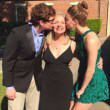

person 108:
Actual: Hispanic
Predicted: Caucasian


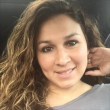

person 109:
Actual: Caucasian
Predicted: Caucasian


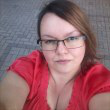

person 110:
Actual: Caucasian
Predicted: Caucasian


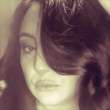

person 111:
Actual: Caucasian
Predicted: Caucasian


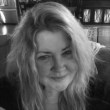

person 112:
Actual: Caucasian
Predicted: Caucasian


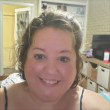

person 113:
Actual: Mixed Race
Predicted: Caucasian


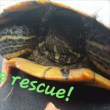

person 114:
Actual: Caucasian
Predicted: Caucasian


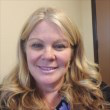

person 115:
Actual: Caucasian
Predicted: Caucasian


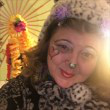

person 117:
Actual: Mixed Race
Predicted: Caucasian


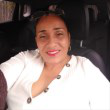

person 118:
Actual: Caucasian
Predicted: Caucasian


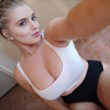

person 119:
Actual: Caucasian
Predicted: Caucasian


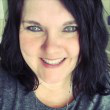

person 120:
Actual: Hispanic
Predicted: Caucasian


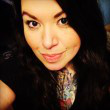

person 121:
Actual: Hispanic
Predicted: Caucasian


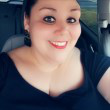

person 122:
Actual: Hispanic
Predicted: Caucasian


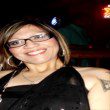

person 123:
Actual: Caucasian
Predicted: Caucasian


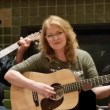

person 125:
Actual: Hispanic
Predicted: Caucasian


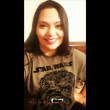

person 127:
Actual: Caucasian
Predicted: Caucasian


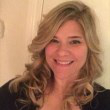

person 128:
Actual: Mixed Race
Predicted: Caucasian


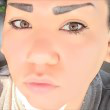

person 129:
Actual: Caucasian
Predicted: Caucasian


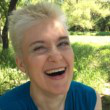

person 130:
Actual: Hispanic
Predicted: Caucasian


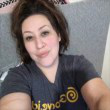

person 131:
Actual: Caucasian
Predicted: Caucasian


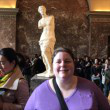

person 132:
Actual: Black
Predicted: Caucasian


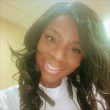

person 133:
Actual: Caucasian
Predicted: Caucasian


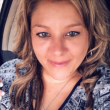

person 134:
Actual: Black
Predicted: Caucasian


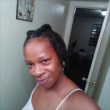

person 135:
Actual: Hispanic
Predicted: Caucasian


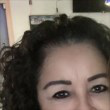

person 136:
Actual: Hispanic
Predicted: Caucasian


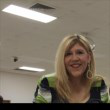

person 137:
Actual: Caucasian
Predicted: Caucasian


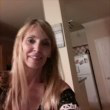

person 139:
Actual: Black
Predicted: Caucasian


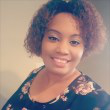

person 140:
Actual: Hispanic
Predicted: Caucasian


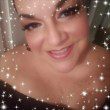

person 141:
Actual: Caucasian
Predicted: Caucasian


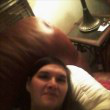

person 142:
Actual: Black
Predicted: Caucasian


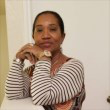

In [37]:
# show the Caucasian Predictions
for intNum in range(0, arrPredict.size):
    if arrPredict[intNum] == 2:
        print(f'person {intNum}:')
        print(f'Actual: {dictYCat[arrTestY[intNum]]}')
        print(f'Predicted: {dictYCat[arrPredict[intNum]]}')
        display(image.array_to_img(arrTestX[intNum]))

person 4:
Actual: Hispanic
Predicted: Hispanic


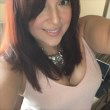

person 11:
Actual: Hispanic
Predicted: Hispanic


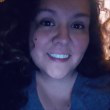

person 22:
Actual: Hispanic
Predicted: Hispanic


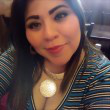

person 29:
Actual: Hispanic
Predicted: Hispanic


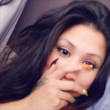

person 31:
Actual: Black
Predicted: Hispanic


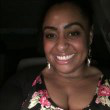

person 35:
Actual: Caucasian
Predicted: Hispanic


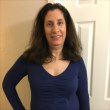

person 39:
Actual: Hispanic
Predicted: Hispanic


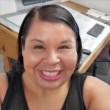

person 47:
Actual: Hispanic
Predicted: Hispanic


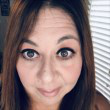

person 59:
Actual: Hispanic
Predicted: Hispanic


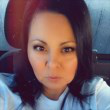

person 71:
Actual: Hispanic
Predicted: Hispanic


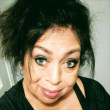

person 79:
Actual: Black
Predicted: Hispanic


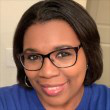

person 80:
Actual: Caucasian
Predicted: Hispanic


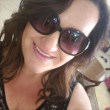

person 89:
Actual: Caucasian
Predicted: Hispanic


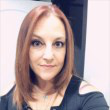

person 90:
Actual: Hispanic
Predicted: Hispanic


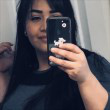

person 98:
Actual: Hispanic
Predicted: Hispanic


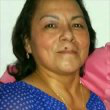

person 100:
Actual: Black
Predicted: Hispanic


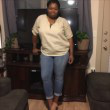

person 116:
Actual: Hispanic
Predicted: Hispanic


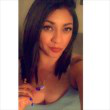

person 124:
Actual: Other Ethnicity
Predicted: Hispanic


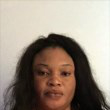

person 126:
Actual: Caucasian
Predicted: Hispanic


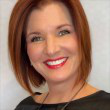

person 138:
Actual: Hispanic
Predicted: Hispanic


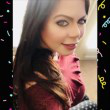

In [38]:
# show the Hispanic Predictions
for intNum in range(0, arrPredict.size):
    if arrPredict[intNum] == 3:
        print(f'person {intNum}:')
        print(f'Actual: {dictYCat[arrTestY[intNum]]}')
        print(f'Predicted: {dictYCat[arrPredict[intNum]]}')
        display(image.array_to_img(arrTestX[intNum]))